# Importing Necessary Libraries

In [1]:
import itertools
## Regular Expression
import re

## Arrays
import numpy as np

## DataFrames
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from IPython.display import Image

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import contractions
import spacy
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('max_columns',40)

# Reading the File

In [3]:
df = pd.read_csv('Cleaned_Women_ECommerce.csv')

In [4]:
df.head()

,Unnamed: 0,clothing_id,age,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,new_text,clean_text,review_length,rating_class,tokens
0,0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and comf...,absolutely wonderful silky sexy comfortable,45,good,"['absolutely', 'wonderful', 'silky', 'sexy', '..."
1,1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happene...,love dress sooo pretty happened find store...,195,good,"['love', 'dress', 'sooo', 'pretty', 'happened'..."
2,2,1077,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,major design flaw high hope dress really wante...,338,neutral,"['major', 'design', 'flaw', 'high', 'hope', 'd..."
3,3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...",favorite buy love love love jumpsuit fun ...,110,good,"['favorite', 'buy', 'love', 'love', 'love', 'j..."
4,4,847,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...,flattering shirt shirt flattering due adjustab...,132,good,"['flattering', 'shirt', 'shirt', 'flattering',..."


In [5]:
df.drop('Unnamed: 0',axis = 1, inplace=True)

# Decreasing the Review Classes to Two (Bad(1,2) & Not Bad(3,4,5))

In [6]:
df.rating_class = df.rating_class.apply(lambda x: x.replace('neutral', 'good'))

In [7]:
df.rating_class = df.rating_class.apply(lambda x: x.replace('good', 'not bad'))

In [8]:
df.rating_class.value_counts()

not bad    20258
bad         2370
Name: rating_class, dtype: int64

# Confusion Matrix Function

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.summer):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

# Natural Language Processing

In [10]:
cleaned_text = [str(txt) for text in df['clean_text'] for txt in text.split(' ') if len(txt)>2 and txt not in 'not, nan']
word_dist = nltk.FreqDist(cleaned_text)

# Adding the Most Common and the Least Common 70 Words to the Stopwords List

In [11]:
stopword_list= stopwords.words('english')
stopword_list= stopwords.words('english')
for y in word_dist.most_common()[-70:]:
    stopword_list.append(y[0])
mst_c = word_dist.most_common()[:70]
for x in mst_c:
    stopword_list.append(x[0])

In [12]:
print(len(stopword_list))

319


In [13]:
lemmatizer = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].map(lambda text: " ".join([lemmatizer.lemmatize(w) for w in text.split(' ') if w not in stopword_list]))

In [14]:
df['rating_class'] = df['rating_class'].apply( lambda x : 0 if x == 'bad' else 1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22628 entries, 0 to 22627
Data columns (total 14 columns):
clothing_id                22628 non-null int64
age                        22628 non-null int64
review_text                22628 non-null object
rating                     22628 non-null int64
recommended_ind            22628 non-null int64
positive_feedback_count    22628 non-null int64
division_name              22628 non-null object
department_name            22628 non-null object
class_name                 22628 non-null object
new_text                   22628 non-null object
clean_text                 22628 non-null object
review_length              22628 non-null int64
rating_class               22628 non-null int64
tokens                     22628 non-null object
dtypes: int64(7), object(7)
memory usage: 2.4+ MB


# Splitting the Data Set into Train and Test Sets

In [16]:
text = df['clean_text']
target = df['rating_class']
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=0.25, random_state=5, stratify = target)

In [17]:
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(16971,)
Test Set Shape		:(5657,)


# Count Vectorizing of the Train and Test Sets

In [18]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=0.001, max_df=0.999)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [19]:
print('Vocabulary len :', len(count_vect.get_feature_names()))
print('Longest word   :', max(count_vect.vocabulary_, key=len))

Vocabulary len : 2627
Longest word   : unfortunately return


In [20]:
vocab = count_vect.get_feature_names()

In [21]:
#vocab = count_vect.get_feature_names()
pd.DataFrame(count_vect_train, columns=vocab).head(5)

,able,able try,absolute,absolutely,absolutely adore,absolutely gorgeous,absolutely loved,absolutely stunning,accent,accentuate,accentuates,accessory,accommodate,according,accurate,accurately,across,across bust,across chest,across shoulder,...,xxsp,yarn,yay,year,year ago,year come,year old,year round,yellow,yes,yesterday,yet,yet still,yoga,young,younger,zero,zip,zipped,zipper
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# CatBoosting With Stating the Categorical Features 

In [22]:
from catboost import CatBoostClassifier

cat_features = list(range(0,2627))
model = CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, loss_function='Logloss')
# Fit model
model.fit(count_vect_train, y_train, cat_features)
# Get predicted classes
preds_class = model.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(preds_class, y_test))

0:	learn: 0.3435190	total: 2.48s	remaining: 1h 1m 54s
1:	learn: 0.3166590	total: 5.32s	remaining: 1h 6m 26s
2:	learn: 0.3060476	total: 7.64s	remaining: 1h 3m 34s
3:	learn: 0.2983551	total: 10.5s	remaining: 1h 5m 31s
4:	learn: 0.2910358	total: 12.6s	remaining: 1h 2m 36s
5:	learn: 0.2871917	total: 14.7s	remaining: 1h 1m 9s
6:	learn: 0.2842434	total: 16.7s	remaining: 59m 26s
7:	learn: 0.2829241	total: 18.7s	remaining: 58m 11s
8:	learn: 0.2801621	total: 20.8s	remaining: 57m 20s
9:	learn: 0.2776691	total: 22.7s	remaining: 56m 25s
10:	learn: 0.2752801	total: 25s	remaining: 56m 24s
11:	learn: 0.2749644	total: 27s	remaining: 55m 46s
12:	learn: 0.2732674	total: 29.2s	remaining: 55m 43s
13:	learn: 0.2710549	total: 31.2s	remaining: 55m 9s
14:	learn: 0.2703292	total: 33.2s	remaining: 54m 43s
15:	learn: 0.2691572	total: 35.5s	remaining: 54m 54s
16:	learn: 0.2687745	total: 37.9s	remaining: 55m 8s
17:	learn: 0.2669888	total: 40.3s	remaining: 55m 18s
18:	learn: 0.2667764	total: 42.6s	remaining: 55m 16

153:	learn: 0.2322655	total: 5m 42s	remaining: 49m 57s
154:	learn: 0.2322020	total: 5m 45s	remaining: 49m 55s
155:	learn: 0.2315706	total: 5m 47s	remaining: 49m 53s
156:	learn: 0.2315646	total: 5m 49s	remaining: 49m 51s
157:	learn: 0.2315470	total: 5m 51s	remaining: 49m 49s
158:	learn: 0.2314099	total: 5m 54s	remaining: 49m 48s
159:	learn: 0.2313864	total: 5m 56s	remaining: 49m 47s
160:	learn: 0.2313361	total: 5m 58s	remaining: 49m 45s
161:	learn: 0.2313131	total: 6m 1s	remaining: 49m 43s
162:	learn: 0.2312465	total: 6m 3s	remaining: 49m 42s
163:	learn: 0.2311795	total: 6m 5s	remaining: 49m 39s
164:	learn: 0.2311237	total: 6m 8s	remaining: 49m 37s
165:	learn: 0.2310593	total: 6m 10s	remaining: 49m 34s
166:	learn: 0.2308387	total: 6m 12s	remaining: 49m 32s
167:	learn: 0.2308292	total: 6m 14s	remaining: 49m 30s
168:	learn: 0.2307941	total: 6m 17s	remaining: 49m 29s
169:	learn: 0.2307634	total: 6m 19s	remaining: 49m 28s
170:	learn: 0.2306890	total: 6m 21s	remaining: 49m 27s
171:	learn: 0.

303:	learn: 0.2214770	total: 11m 35s	remaining: 45m 38s
304:	learn: 0.2214359	total: 11m 38s	remaining: 45m 35s
305:	learn: 0.2212948	total: 11m 40s	remaining: 45m 33s
306:	learn: 0.2212464	total: 11m 42s	remaining: 45m 30s
307:	learn: 0.2212037	total: 11m 44s	remaining: 45m 28s
308:	learn: 0.2211349	total: 11m 47s	remaining: 45m 25s
309:	learn: 0.2211185	total: 11m 49s	remaining: 45m 23s
310:	learn: 0.2210575	total: 11m 51s	remaining: 45m 21s
311:	learn: 0.2210165	total: 11m 54s	remaining: 45m 19s
312:	learn: 0.2210160	total: 11m 56s	remaining: 45m 16s
313:	learn: 0.2209903	total: 11m 58s	remaining: 45m 13s
314:	learn: 0.2208026	total: 12m	remaining: 45m 11s
315:	learn: 0.2207783	total: 12m 3s	remaining: 45m 9s
316:	learn: 0.2206613	total: 12m 5s	remaining: 45m 6s
317:	learn: 0.2206331	total: 12m 7s	remaining: 45m 3s
318:	learn: 0.2205846	total: 12m 9s	remaining: 45m 1s
319:	learn: 0.2205818	total: 12m 11s	remaining: 44m 59s
320:	learn: 0.2205733	total: 12m 14s	remaining: 44m 56s
321:

451:	learn: 0.2155269	total: 17m 16s	remaining: 40m 2s
452:	learn: 0.2154490	total: 17m 18s	remaining: 40m
453:	learn: 0.2154284	total: 17m 20s	remaining: 39m 57s
454:	learn: 0.2153240	total: 17m 22s	remaining: 39m 55s
455:	learn: 0.2153227	total: 17m 25s	remaining: 39m 53s
456:	learn: 0.2153204	total: 17m 27s	remaining: 39m 50s
457:	learn: 0.2153200	total: 17m 29s	remaining: 39m 48s
458:	learn: 0.2153162	total: 17m 32s	remaining: 39m 45s
459:	learn: 0.2152895	total: 17m 34s	remaining: 39m 43s
460:	learn: 0.2151322	total: 17m 36s	remaining: 39m 41s
461:	learn: 0.2150613	total: 17m 38s	remaining: 39m 38s
462:	learn: 0.2150071	total: 17m 41s	remaining: 39m 36s
463:	learn: 0.2149147	total: 17m 43s	remaining: 39m 34s
464:	learn: 0.2149147	total: 17m 45s	remaining: 39m 31s
465:	learn: 0.2149130	total: 17m 47s	remaining: 39m 29s
466:	learn: 0.2149130	total: 17m 50s	remaining: 39m 27s
467:	learn: 0.2148820	total: 17m 52s	remaining: 39m 24s
468:	learn: 0.2148636	total: 17m 54s	remaining: 39m 2

599:	learn: 0.2110598	total: 22m 54s	remaining: 34m 21s
600:	learn: 0.2110541	total: 22m 56s	remaining: 34m 19s
601:	learn: 0.2110255	total: 22m 59s	remaining: 34m 17s
602:	learn: 0.2110243	total: 23m 1s	remaining: 34m 14s
603:	learn: 0.2109882	total: 23m 3s	remaining: 34m 12s
604:	learn: 0.2109869	total: 23m 5s	remaining: 34m 10s
605:	learn: 0.2109725	total: 23m 8s	remaining: 34m 7s
606:	learn: 0.2109721	total: 23m 10s	remaining: 34m 5s
607:	learn: 0.2109720	total: 23m 12s	remaining: 34m 3s
608:	learn: 0.2109678	total: 23m 15s	remaining: 34m 1s
609:	learn: 0.2109616	total: 23m 17s	remaining: 33m 59s
610:	learn: 0.2109560	total: 23m 20s	remaining: 33m 57s
611:	learn: 0.2109557	total: 23m 22s	remaining: 33m 54s
612:	learn: 0.2109115	total: 23m 24s	remaining: 33m 52s
613:	learn: 0.2109085	total: 23m 27s	remaining: 33m 50s
614:	learn: 0.2109084	total: 23m 29s	remaining: 33m 48s
615:	learn: 0.2108789	total: 23m 31s	remaining: 33m 46s
616:	learn: 0.2108786	total: 23m 34s	remaining: 33m 43s


747:	learn: 0.2078026	total: 28m 34s	remaining: 28m 43s
748:	learn: 0.2077510	total: 28m 37s	remaining: 28m 41s
749:	learn: 0.2077483	total: 28m 39s	remaining: 28m 39s
750:	learn: 0.2076984	total: 28m 41s	remaining: 28m 37s
751:	learn: 0.2076941	total: 28m 44s	remaining: 28m 34s
752:	learn: 0.2076846	total: 28m 46s	remaining: 28m 32s
753:	learn: 0.2076623	total: 28m 48s	remaining: 28m 30s
754:	learn: 0.2075134	total: 28m 50s	remaining: 28m 28s
755:	learn: 0.2074668	total: 28m 53s	remaining: 28m 25s
756:	learn: 0.2074627	total: 28m 55s	remaining: 28m 23s
757:	learn: 0.2074495	total: 28m 57s	remaining: 28m 21s
758:	learn: 0.2074314	total: 29m	remaining: 28m 18s
759:	learn: 0.2073806	total: 29m 2s	remaining: 28m 16s
760:	learn: 0.2073780	total: 29m 4s	remaining: 28m 14s
761:	learn: 0.2073764	total: 29m 7s	remaining: 28m 12s
762:	learn: 0.2073591	total: 29m 9s	remaining: 28m 9s
763:	learn: 0.2073545	total: 29m 11s	remaining: 28m 7s
764:	learn: 0.2073154	total: 29m 13s	remaining: 28m 5s
765

895:	learn: 0.2041484	total: 34m 13s	remaining: 23m 4s
896:	learn: 0.2041396	total: 34m 15s	remaining: 23m 1s
897:	learn: 0.2041389	total: 34m 17s	remaining: 22m 59s
898:	learn: 0.2041367	total: 34m 20s	remaining: 22m 57s
899:	learn: 0.2040584	total: 34m 22s	remaining: 22m 54s
900:	learn: 0.2040583	total: 34m 24s	remaining: 22m 52s
901:	learn: 0.2040583	total: 34m 27s	remaining: 22m 50s
902:	learn: 0.2040525	total: 34m 29s	remaining: 22m 48s
903:	learn: 0.2040461	total: 34m 31s	remaining: 22m 45s
904:	learn: 0.2040212	total: 34m 34s	remaining: 22m 43s
905:	learn: 0.2040102	total: 34m 36s	remaining: 22m 41s
906:	learn: 0.2040056	total: 34m 38s	remaining: 22m 39s
907:	learn: 0.2040054	total: 34m 41s	remaining: 22m 36s
908:	learn: 0.2039483	total: 34m 43s	remaining: 22m 34s
909:	learn: 0.2039214	total: 34m 45s	remaining: 22m 32s
910:	learn: 0.2039212	total: 34m 47s	remaining: 22m 29s
911:	learn: 0.2039211	total: 34m 50s	remaining: 22m 27s
912:	learn: 0.2038395	total: 34m 52s	remaining: 22

1042:	learn: 0.2015820	total: 39m 49s	remaining: 17m 26s
1043:	learn: 0.2015787	total: 39m 51s	remaining: 17m 24s
1044:	learn: 0.2013858	total: 39m 54s	remaining: 17m 22s
1045:	learn: 0.2013670	total: 39m 56s	remaining: 17m 20s
1046:	learn: 0.2013667	total: 39m 58s	remaining: 17m 17s
1047:	learn: 0.2012201	total: 40m 1s	remaining: 17m 15s
1048:	learn: 0.2012198	total: 40m 3s	remaining: 17m 13s
1049:	learn: 0.2012131	total: 40m 5s	remaining: 17m 10s
1050:	learn: 0.2012117	total: 40m 7s	remaining: 17m 8s
1051:	learn: 0.2012114	total: 40m 10s	remaining: 17m 6s
1052:	learn: 0.2012074	total: 40m 12s	remaining: 17m 4s
1053:	learn: 0.2012001	total: 40m 14s	remaining: 17m 1s
1054:	learn: 0.2011965	total: 40m 17s	remaining: 16m 59s
1055:	learn: 0.2011962	total: 40m 19s	remaining: 16m 57s
1056:	learn: 0.2011843	total: 40m 21s	remaining: 16m 54s
1057:	learn: 0.2011802	total: 40m 24s	remaining: 16m 52s
1058:	learn: 0.2011758	total: 40m 26s	remaining: 16m 50s
1059:	learn: 0.2011737	total: 40m 28s	r

1187:	learn: 0.1988564	total: 45m 24s	remaining: 11m 55s
1188:	learn: 0.1988440	total: 45m 27s	remaining: 11m 53s
1189:	learn: 0.1988423	total: 45m 29s	remaining: 11m 51s
1190:	learn: 0.1988405	total: 45m 31s	remaining: 11m 48s
1191:	learn: 0.1988399	total: 45m 34s	remaining: 11m 46s
1192:	learn: 0.1986982	total: 45m 36s	remaining: 11m 44s
1193:	learn: 0.1986816	total: 45m 38s	remaining: 11m 41s
1194:	learn: 0.1986691	total: 45m 41s	remaining: 11m 39s
1195:	learn: 0.1986395	total: 45m 43s	remaining: 11m 37s
1196:	learn: 0.1986345	total: 45m 45s	remaining: 11m 35s
1197:	learn: 0.1986338	total: 45m 48s	remaining: 11m 32s
1198:	learn: 0.1986282	total: 45m 50s	remaining: 11m 30s
1199:	learn: 0.1986280	total: 45m 52s	remaining: 11m 28s
1200:	learn: 0.1986018	total: 45m 55s	remaining: 11m 25s
1201:	learn: 0.1985504	total: 45m 57s	remaining: 11m 23s
1202:	learn: 0.1985447	total: 45m 59s	remaining: 11m 21s
1203:	learn: 0.1985304	total: 46m 2s	remaining: 11m 19s
1204:	learn: 0.1985109	total: 46

1334:	learn: 0.1963327	total: 51m 6s	remaining: 6m 18s
1335:	learn: 0.1963322	total: 51m 8s	remaining: 6m 16s
1336:	learn: 0.1963317	total: 51m 11s	remaining: 6m 14s
1337:	learn: 0.1963314	total: 51m 13s	remaining: 6m 12s
1338:	learn: 0.1963105	total: 51m 15s	remaining: 6m 9s
1339:	learn: 0.1963024	total: 51m 18s	remaining: 6m 7s
1340:	learn: 0.1962995	total: 51m 20s	remaining: 6m 5s
1341:	learn: 0.1962966	total: 51m 22s	remaining: 6m 2s
1342:	learn: 0.1962966	total: 51m 25s	remaining: 6m
1343:	learn: 0.1962864	total: 51m 27s	remaining: 5m 58s
1344:	learn: 0.1962851	total: 51m 30s	remaining: 5m 56s
1345:	learn: 0.1962848	total: 51m 32s	remaining: 5m 53s
1346:	learn: 0.1962800	total: 51m 34s	remaining: 5m 51s
1347:	learn: 0.1961993	total: 51m 36s	remaining: 5m 49s
1348:	learn: 0.1961639	total: 51m 39s	remaining: 5m 46s
1349:	learn: 0.1961483	total: 51m 41s	remaining: 5m 44s
1350:	learn: 0.1961368	total: 51m 43s	remaining: 5m 42s
1351:	learn: 0.1961361	total: 51m 46s	remaining: 5m 40s
13

1482:	learn: 0.1934809	total: 56m 51s	remaining: 39.1s
1483:	learn: 0.1934787	total: 56m 53s	remaining: 36.8s
1484:	learn: 0.1934724	total: 56m 55s	remaining: 34.5s
1485:	learn: 0.1934562	total: 56m 58s	remaining: 32.2s
1486:	learn: 0.1934561	total: 57m	remaining: 29.9s
1487:	learn: 0.1934539	total: 57m 2s	remaining: 27.6s
1488:	learn: 0.1933753	total: 57m 5s	remaining: 25.3s
1489:	learn: 0.1933677	total: 57m 7s	remaining: 23s
1490:	learn: 0.1933539	total: 57m 9s	remaining: 20.7s
1491:	learn: 0.1933538	total: 57m 12s	remaining: 18.4s
1492:	learn: 0.1933538	total: 57m 14s	remaining: 16.1s
1493:	learn: 0.1933538	total: 57m 16s	remaining: 13.8s
1494:	learn: 0.1933502	total: 57m 19s	remaining: 11.5s
1495:	learn: 0.1933495	total: 57m 21s	remaining: 9.2s
1496:	learn: 0.1933495	total: 57m 23s	remaining: 6.9s
1497:	learn: 0.1933428	total: 57m 25s	remaining: 4.6s
1498:	learn: 0.1933415	total: 57m 28s	remaining: 2.3s
1499:	learn: 0.1933257	total: 57m 30s	remaining: 0us
Accuracy : 0.9052501325791

In [23]:
print (classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.59      0.30      0.40       592
          1       0.92      0.98      0.95      5065

avg / total       0.89      0.91      0.89      5657



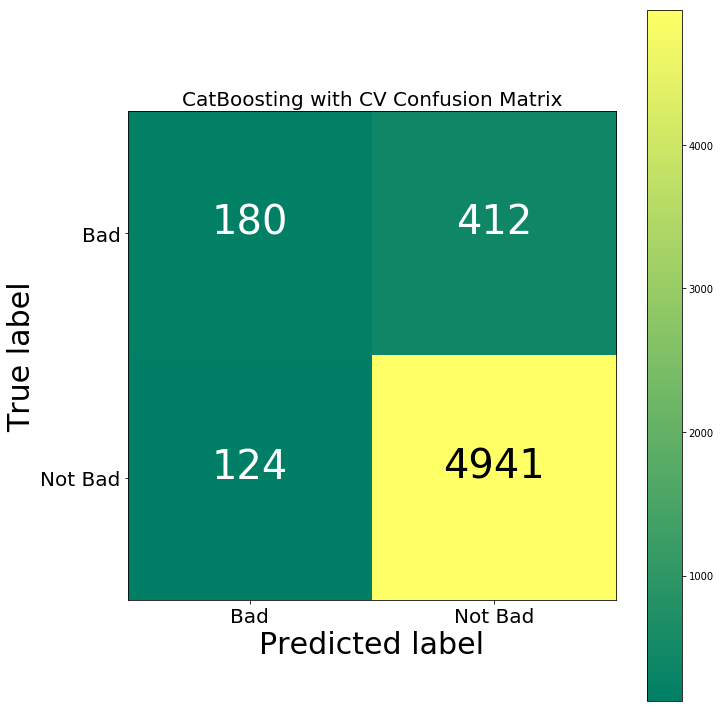

[[ 180  412]
 [ 124 4941]]


In [26]:
cm = confusion_matrix(y_test, preds_class)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='CatBoosting with CV Confusion Matrix')
plt.show()
print(cm)

# Catboosting Without Stating the Categorical Features

In [27]:
from catboost import CatBoostClassifier

#cat_features = list(range(0,2627))
model = CatBoostClassifier(iterations=1000, learning_rate=0.8, depth=2, loss_function='Logloss')
# Fit model
model.fit(count_vect_train, y_train)
# Get predicted classes
preds_class = model.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, preds_class))

0:	learn: 0.3449956	total: 200ms	remaining: 3m 19s
1:	learn: 0.3178347	total: 410ms	remaining: 3m 24s
2:	learn: 0.3061899	total: 662ms	remaining: 3m 40s
3:	learn: 0.3003270	total: 866ms	remaining: 3m 35s
4:	learn: 0.2913977	total: 1.04s	remaining: 3m 27s
5:	learn: 0.2852128	total: 1.22s	remaining: 3m 21s
6:	learn: 0.2800042	total: 1.42s	remaining: 3m 21s
7:	learn: 0.2774449	total: 1.65s	remaining: 3m 24s
8:	learn: 0.2754671	total: 1.86s	remaining: 3m 25s
9:	learn: 0.2742092	total: 2.04s	remaining: 3m 22s
10:	learn: 0.2712778	total: 2.23s	remaining: 3m 20s
11:	learn: 0.2687695	total: 2.42s	remaining: 3m 19s
12:	learn: 0.2674601	total: 2.61s	remaining: 3m 18s
13:	learn: 0.2652902	total: 2.81s	remaining: 3m 17s
14:	learn: 0.2637240	total: 3.01s	remaining: 3m 17s
15:	learn: 0.2616773	total: 3.18s	remaining: 3m 15s
16:	learn: 0.2600704	total: 3.38s	remaining: 3m 15s
17:	learn: 0.2582348	total: 3.56s	remaining: 3m 14s
18:	learn: 0.2575806	total: 3.74s	remaining: 3m 13s
19:	learn: 0.2568469	t

159:	learn: 0.2057457	total: 30.3s	remaining: 2m 39s
160:	learn: 0.2053265	total: 30.5s	remaining: 2m 38s
161:	learn: 0.2051574	total: 30.6s	remaining: 2m 38s
162:	learn: 0.2051411	total: 30.8s	remaining: 2m 38s
163:	learn: 0.2050669	total: 31s	remaining: 2m 38s
164:	learn: 0.2047052	total: 31.2s	remaining: 2m 37s
165:	learn: 0.2046320	total: 31.4s	remaining: 2m 37s
166:	learn: 0.2046262	total: 31.6s	remaining: 2m 37s
167:	learn: 0.2043086	total: 31.8s	remaining: 2m 37s
168:	learn: 0.2042418	total: 31.9s	remaining: 2m 37s
169:	learn: 0.2042231	total: 32.1s	remaining: 2m 36s
170:	learn: 0.2042099	total: 32.3s	remaining: 2m 36s
171:	learn: 0.2041721	total: 32.5s	remaining: 2m 36s
172:	learn: 0.2040885	total: 32.6s	remaining: 2m 36s
173:	learn: 0.2034127	total: 32.8s	remaining: 2m 35s
174:	learn: 0.2033768	total: 33s	remaining: 2m 35s
175:	learn: 0.2033532	total: 33.2s	remaining: 2m 35s
176:	learn: 0.2031218	total: 33.3s	remaining: 2m 35s
177:	learn: 0.2030356	total: 33.5s	remaining: 2m 3

315:	learn: 0.1862589	total: 58.5s	remaining: 2m 6s
316:	learn: 0.1862095	total: 58.7s	remaining: 2m 6s
317:	learn: 0.1853005	total: 58.8s	remaining: 2m 6s
318:	learn: 0.1852872	total: 59s	remaining: 2m 5s
319:	learn: 0.1852849	total: 59.2s	remaining: 2m 5s
320:	learn: 0.1850810	total: 59.4s	remaining: 2m 5s
321:	learn: 0.1849320	total: 59.6s	remaining: 2m 5s
322:	learn: 0.1849315	total: 59.9s	remaining: 2m 5s
323:	learn: 0.1848745	total: 1m	remaining: 2m 5s
324:	learn: 0.1848744	total: 1m	remaining: 2m 5s
325:	learn: 0.1847092	total: 1m	remaining: 2m 5s
326:	learn: 0.1847049	total: 1m	remaining: 2m 4s
327:	learn: 0.1846975	total: 1m	remaining: 2m 4s
328:	learn: 0.1845887	total: 1m 1s	remaining: 2m 4s
329:	learn: 0.1844190	total: 1m 1s	remaining: 2m 4s
330:	learn: 0.1842108	total: 1m 1s	remaining: 2m 4s
331:	learn: 0.1842103	total: 1m 1s	remaining: 2m 3s
332:	learn: 0.1842056	total: 1m 1s	remaining: 2m 3s
333:	learn: 0.1842056	total: 1m 1s	remaining: 2m 3s
334:	learn: 0.1841042	total: 

470:	learn: 0.1727775	total: 1m 27s	remaining: 1m 38s
471:	learn: 0.1727176	total: 1m 27s	remaining: 1m 38s
472:	learn: 0.1727144	total: 1m 28s	remaining: 1m 38s
473:	learn: 0.1727071	total: 1m 28s	remaining: 1m 37s
474:	learn: 0.1727055	total: 1m 28s	remaining: 1m 37s
475:	learn: 0.1725541	total: 1m 28s	remaining: 1m 37s
476:	learn: 0.1725438	total: 1m 28s	remaining: 1m 37s
477:	learn: 0.1723772	total: 1m 28s	remaining: 1m 37s
478:	learn: 0.1723141	total: 1m 29s	remaining: 1m 36s
479:	learn: 0.1722984	total: 1m 29s	remaining: 1m 36s
480:	learn: 0.1721484	total: 1m 29s	remaining: 1m 36s
481:	learn: 0.1719940	total: 1m 29s	remaining: 1m 36s
482:	learn: 0.1719739	total: 1m 29s	remaining: 1m 36s
483:	learn: 0.1718505	total: 1m 30s	remaining: 1m 36s
484:	learn: 0.1718482	total: 1m 30s	remaining: 1m 35s
485:	learn: 0.1716711	total: 1m 30s	remaining: 1m 35s
486:	learn: 0.1716490	total: 1m 30s	remaining: 1m 35s
487:	learn: 0.1716380	total: 1m 30s	remaining: 1m 35s
488:	learn: 0.1716322	total:

622:	learn: 0.1647147	total: 1m 58s	remaining: 1m 11s
623:	learn: 0.1647089	total: 1m 58s	remaining: 1m 11s
624:	learn: 0.1646556	total: 1m 58s	remaining: 1m 11s
625:	learn: 0.1645917	total: 1m 58s	remaining: 1m 11s
626:	learn: 0.1645665	total: 1m 59s	remaining: 1m 10s
627:	learn: 0.1645656	total: 1m 59s	remaining: 1m 10s
628:	learn: 0.1645633	total: 1m 59s	remaining: 1m 10s
629:	learn: 0.1645563	total: 1m 59s	remaining: 1m 10s
630:	learn: 0.1645418	total: 1m 59s	remaining: 1m 10s
631:	learn: 0.1645208	total: 2m	remaining: 1m 9s
632:	learn: 0.1644083	total: 2m	remaining: 1m 9s
633:	learn: 0.1643833	total: 2m	remaining: 1m 9s
634:	learn: 0.1642530	total: 2m	remaining: 1m 9s
635:	learn: 0.1641950	total: 2m	remaining: 1m 9s
636:	learn: 0.1641752	total: 2m 1s	remaining: 1m 8s
637:	learn: 0.1641743	total: 2m 1s	remaining: 1m 8s
638:	learn: 0.1640710	total: 2m 1s	remaining: 1m 8s
639:	learn: 0.1640052	total: 2m 1s	remaining: 1m 8s
640:	learn: 0.1640044	total: 2m 1s	remaining: 1m 8s
641:	lear

779:	learn: 0.1580834	total: 2m 31s	remaining: 42.7s
780:	learn: 0.1580817	total: 2m 31s	remaining: 42.6s
781:	learn: 0.1580687	total: 2m 32s	remaining: 42.4s
782:	learn: 0.1580675	total: 2m 32s	remaining: 42.2s
783:	learn: 0.1580570	total: 2m 32s	remaining: 42s
784:	learn: 0.1580016	total: 2m 32s	remaining: 41.9s
785:	learn: 0.1579959	total: 2m 33s	remaining: 41.7s
786:	learn: 0.1578626	total: 2m 33s	remaining: 41.5s
787:	learn: 0.1578568	total: 2m 33s	remaining: 41.3s
788:	learn: 0.1578563	total: 2m 33s	remaining: 41.1s
789:	learn: 0.1578556	total: 2m 33s	remaining: 40.9s
790:	learn: 0.1578518	total: 2m 34s	remaining: 40.7s
791:	learn: 0.1578483	total: 2m 34s	remaining: 40.5s
792:	learn: 0.1577964	total: 2m 34s	remaining: 40.3s
793:	learn: 0.1576033	total: 2m 34s	remaining: 40.1s
794:	learn: 0.1576009	total: 2m 34s	remaining: 40s
795:	learn: 0.1575551	total: 2m 35s	remaining: 39.8s
796:	learn: 0.1575512	total: 2m 35s	remaining: 39.6s
797:	learn: 0.1575159	total: 2m 35s	remaining: 39.

935:	learn: 0.1512516	total: 3m 6s	remaining: 12.8s
936:	learn: 0.1512461	total: 3m 7s	remaining: 12.6s
937:	learn: 0.1512445	total: 3m 7s	remaining: 12.4s
938:	learn: 0.1512424	total: 3m 7s	remaining: 12.2s
939:	learn: 0.1510832	total: 3m 8s	remaining: 12s
940:	learn: 0.1509179	total: 3m 8s	remaining: 11.8s
941:	learn: 0.1508772	total: 3m 8s	remaining: 11.6s
942:	learn: 0.1508759	total: 3m 8s	remaining: 11.4s
943:	learn: 0.1508750	total: 3m 9s	remaining: 11.2s
944:	learn: 0.1508613	total: 3m 9s	remaining: 11s
945:	learn: 0.1508549	total: 3m 9s	remaining: 10.8s
946:	learn: 0.1508437	total: 3m 9s	remaining: 10.6s
947:	learn: 0.1507992	total: 3m 9s	remaining: 10.4s
948:	learn: 0.1507963	total: 3m 10s	remaining: 10.2s
949:	learn: 0.1507399	total: 3m 10s	remaining: 10s
950:	learn: 0.1507365	total: 3m 10s	remaining: 9.82s
951:	learn: 0.1507324	total: 3m 10s	remaining: 9.63s
952:	learn: 0.1507305	total: 3m 11s	remaining: 9.43s
953:	learn: 0.1506355	total: 3m 11s	remaining: 9.23s
954:	learn: 

In [28]:
print (classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.57      0.35      0.44       592
          1       0.93      0.97      0.95      5065

avg / total       0.89      0.90      0.89      5657



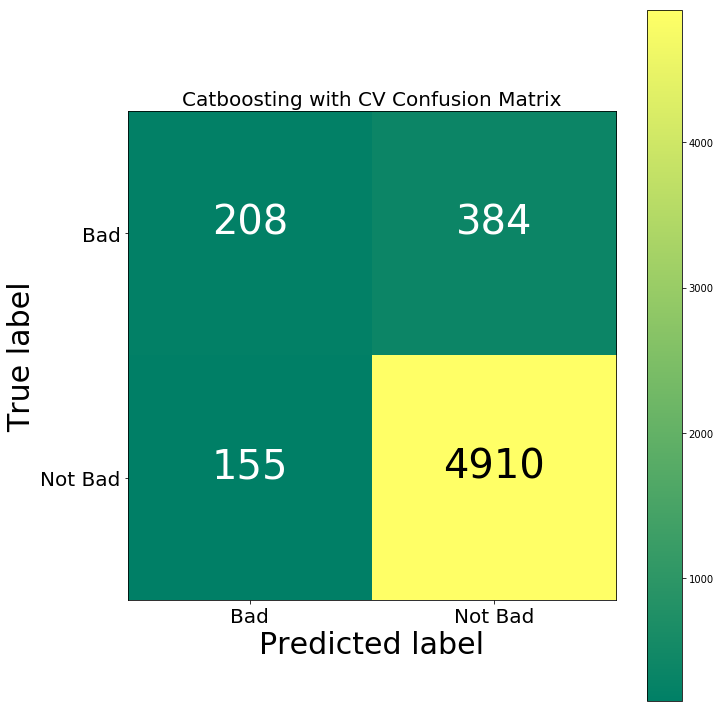

[[ 208  384]
 [ 155 4910]]


In [30]:
cm = confusion_matrix(y_test,preds_class)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='Catboosting with CV Confusion Matrix')
plt.show()
print(cm)

# TPOT

In [28]:
from tpot import TPOTClassifier

tpot_classifier = TPOTClassifier(max_time_mins=300,
                                    generations=50, 
                                    population_size=50, cv=5,
                                    random_state=5, 
                                    verbosity=2, 
                                    n_jobs = -1)
tpot_classifier.fit(count_vect_train, y_train)
print(tpot_classifier.score(count_vect_test, y_test))
tpot_classifier.export('tpot_Womenecommerce.py')

A Jupyter Widget

Generation 1 - Current best internal CV score: 0.9101998700434534
Generation 2 - Current best internal CV score: 0.9101998700434534
Generation 3 - Current best internal CV score: 0.9101998700434534
Generation 4 - Current best internal CV score: 0.9101998700434534
Generation 5 - Current best internal CV score: 0.9101998700434534

307.6519573166667 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LinearSVC(input_matrix, C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=1e-05)
0.911613929644688


**tpot_Womenecommerce.py:**

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

NOTE: Make sure that the class is labeled 'target' in the data file

tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=5)

Average CV score on the training set was:0.9101998700434534

exported_pipeline = LinearSVC(C=0.01, dual=False, loss="squared_hinge", penalty="l2", tol=1e-05)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)
**___________________________________________________**

# Linear SVC with CV

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# NOTE: Make sure that the class is labeled 'target' in the data file
model = LinearSVC(C=0.01, dual=False, loss="squared_hinge", penalty="l2", tol=1e-05)

model.fit(count_vect_train, y_train)
model.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, model.predict(count_vect_test)))

Accuracy : 0.911613929644688


In [37]:
print (classification_report(y_test, model.predict(count_vect_test)))

             precision    recall  f1-score   support

          0       0.69      0.28      0.40       592
          1       0.92      0.99      0.95      5065

avg / total       0.90      0.91      0.89      5657



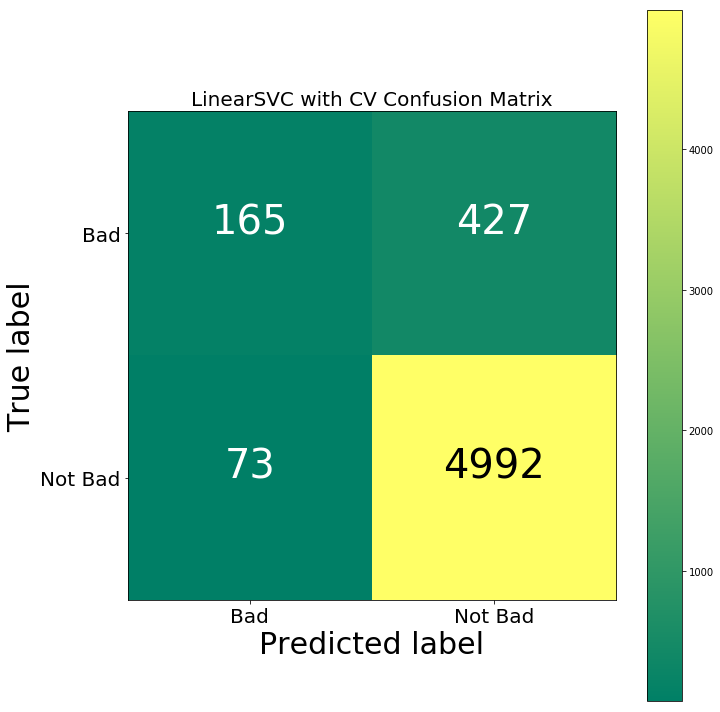

[[ 165  427]
 [  73 4992]]


In [38]:
cm = confusion_matrix(y_test,model.predict(count_vect_test))
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='LinearSVC with CV Confusion Matrix')
plt.show()
print(cm)

In [40]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from tabulate import tabulate

In [48]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from C:\Users\Mike\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Mike\AppData\Local\Temp\tmpzky_jtel
  JVM stdout: C:\Users\Mike\AppData\Local\Temp\tmpzky_jtel\h2o_Mike_started_from_python.out
  JVM stderr: C:\Users\Mike\AppData\Local\Temp\tmpzky_jtel\h2o_Mike_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.7
H2O cluster version age:,20 days
H2O cluster name:,H2O_from_python_Mike_24ixu2
H2O cluster total nodes:,1
H2O cluster free memory:,3.545 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [41]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=0.001, max_df=0.999)
count_vect_train_h2o = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train_h2o.toarray()
count_vect_test_h2o = count_vect.transform(X_test)
count_vect_test = count_vect_test_h2o.toarray()

In [44]:
df_h2o_train = pd.DataFrame(count_vect_train, columns=vocab).head(5)

In [51]:
df_h2o_train = pd.concat([df_h2o_train, y_train], ignore_index=True)

In [45]:
df_h2o_test = pd.DataFrame(count_vect_test, columns=vocab).head(5)

In [52]:
df_h2o_test = pd.concat([df_h2o_test, y_test], ignore_index=True)

In [ ]:
df_h2o_test.head()

In [49]:
h2o_df_train = h2o.H2OFrame(df_h2o_train)
h2o_df_test = h2o.H2OFrame(df_h2o_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
# Build a Generalized Linear Model (GLM) with default settings

# Import the function for GLM
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# Set up GLM for binary classification
glm_default = H2OGeneralizedLinearEstimator(family = 'binomial', model_id = 'glm_default')

# Use .train() to build the model
glm_default.train(x = features, 
                  y = 'Survived', 
                  training_frame = titanic_train)

NameError: name 'features' is not defined